# pose estimation with MoveNet

## 0. Installing and Importing Dependencies

In [139]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

from IPython.display import display, Image
# import ipywidgets as widgets
import threading

## 1. Loading model

[Link to model and official docs](https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/3)

website -> model format -> TFLite (movenet/singlepose/lightning) -> model card

*  MoveNet.SinglePose.Lightning: A lower capacity model that can run >50FPS on most modern laptops while achieving good performance.
* MoveNet.SinglePose.Thunder: A higher capacity model that performs better prediction
quality while still achieving real-time (>30FPS) speed. Naturally, thunder will lag behind
the lightning, but it will pack more of a punch.

gonna stick with Lightening first; download it and have it in the current directory

In [140]:
interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


## 2. Detection

### Taking live-streaming camera input

[!!] it appears that my machine has some issues regarding opening an OpenCV camera window for live video; code written following the official documentation and **should** run always fails with the following message:
```
[ WARN:0@5.798] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
```

I have tried different solutions online that none of them work for my case.

The workaround:
* since the livestreaming for Django web app works with no issue, we may assume that our server's livecam should work normally
* as the current step, for testing purposes, we are gonna rely on images for testing.

In [141]:
frameWidth = 640
frameHeight = 480
cap = cv2.VideoCapture(0)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)


while cap.isOpened():
    cap.release()
    break 
    success, img = cap.read()
    if success:
        cv2.imshow("Result", img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print('oof')

[ WARN:0@3963.543] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


[ WARN:0@3965.475] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


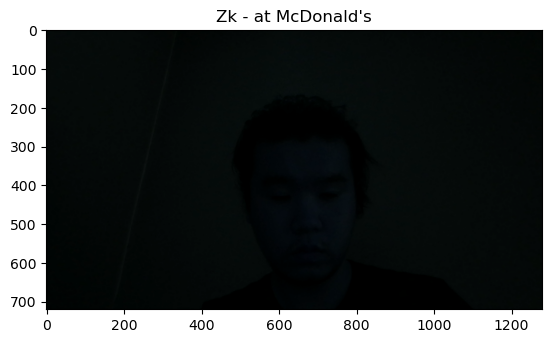

In [142]:
# init camera
camera = cv2.VideoCapture(0)

# Grab a single frame of video
ret, frame = camera.read()

# show camera frame
plt.imshow(frame)
plt.title('Zk - at McDonald\'s')
plt.show()

# close camera
camera.release()

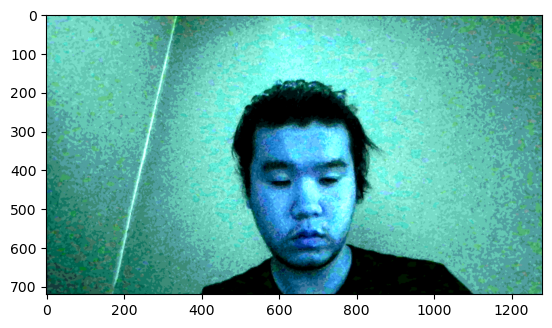

In [143]:
adjusted = cv2.convertScaleAbs(frame, 0.5, 20)
plt.imshow(adjusted)

In [144]:
# taking input from webcam: the alternative version
cap = cv2.VideoCapture(0)
cap.set(3,640) # adjust width
cap.set(4,480) # adjust height

while True:
    cap.release()
    break
    success, img = cap.read()
    cv2.imshow("Webcam", img) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window doesn't close

[ WARN:0@3967.460] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_5a1v4y7k9y/croot/opencv-suite_1676472757237/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


-1

### Taking image input


original size:  (720, 1280, 3)


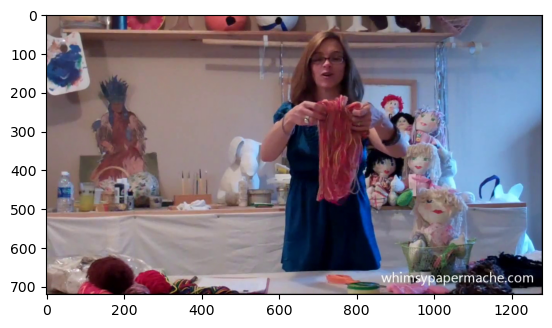

In [145]:
file_name = "mpii/000024100.jpg"
image = plt.imread(file_name)
plt.imshow(image)
print("original size: ", image.shape)

In [146]:
img = image.copy()

In [147]:
np.expand_dims(img, axis=0).shape

(1, 720, 1280, 3)

In [148]:
# Reshape image: 192x192x3 (Lightning)
img = image.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
print(tf.shape(img))
input_image = tf.cast(img, dtype=tf.float32)

tf.Tensor([  1 192 192   3], shape=(4,), dtype=int32)


In [149]:
# Setup input and output 
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 312, 'shape': array([ 1,  1, 17,  3], dtype=int32), 'shape_signature': array([ 1,  1, 17,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [150]:
# Make predictions 
interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
print(keypoints_with_scores)
print(keypoints_with_scores.shape)

[[[[0.3176961  0.56976616 0.7305902 ]
   [0.3079455  0.58297276 0.6289664 ]
   [0.3070959  0.5549848  0.67248875]
   [0.31879634 0.5939856  0.70116955]
   [0.31857738 0.53713626 0.7591909 ]
   [0.3951785  0.62601364 0.692966  ]
   [0.40339833 0.496799   0.58398867]
   [0.49925214 0.68700624 0.49507758]
   [0.51221424 0.4366877  0.6711895 ]
   [0.46737993 0.70381904 0.31005466]
   [0.42566597 0.49296162 0.56486493]
   [0.6410847  0.6104063  0.71210325]
   [0.6420876  0.5185299  0.63804084]
   [0.77429104 0.6282876  0.21687686]
   [0.7776215  0.5229952  0.27453357]
   [0.7701082  0.63266975 0.01607544]
   [0.76757884 0.53529745 0.02070558]]]]
(1, 1, 17, 3)


## 3. Rendering

### Drawing keypoints

In [151]:
# some examples
right_eye = keypoints_with_scores[0,0,2]
left_elbow = keypoints_with_scores[0,0,7]

In [152]:
left_elbow

array([0.49925214, 0.68700624, 0.49507758], dtype=float32)

In [153]:
left_elbow_pt = np.array(left_elbow[:2]*[720,1280]).astype(int)
right_eye_pt = np.array(right_eye[:2]*[720,1280]).astype(int)

[359 879]
[0.3070959  0.5549848  0.67248875]


In [164]:
right_elbow = keypoints_with_scores[0,0,8]
right_elbow_pt = np.array(right_elbow[:2]*[720,1280]).astype(int)
print(right_elbow_pt)

[368 558]


In [166]:
nose = keypoints_with_scores[0,0,0]
nose_pt = np.array(nose[:2]*[720,1280]).astype(int)
print(nose_pt)

[228 729]


In [159]:
print(left_elbow_pt)
print(right_eye_pt)

[359 879]
[221 710]


In [172]:
left_shoulder = keypoints_with_scores[0,0,5]
left_shoulder_pt = np.array(left_shoulder[:2]*[720,1280]).astype(int)
print(left_shoulder_pt)

[284 801]


In [181]:
right_shoulder = keypoints_with_scores[0,0,6]
right_shoulder_pt = np.array(right_shoulder[:2]*[720,1280]).astype(int)
print(right_shoulder_pt)

[290 635]


In [184]:
left_hip  = keypoints_with_scores[0,0,11]
left_hip_pt = np.array(left_hip[:2]*[720,1280]).astype(int)
print(left_hip_pt)
right_hip = keypoints_with_scores[0,0,12]
right_hip_pt = np.array(right_hip[:2]*[720,1280]).astype(int)
print(right_hip_pt)

[461 781]
[462 663]


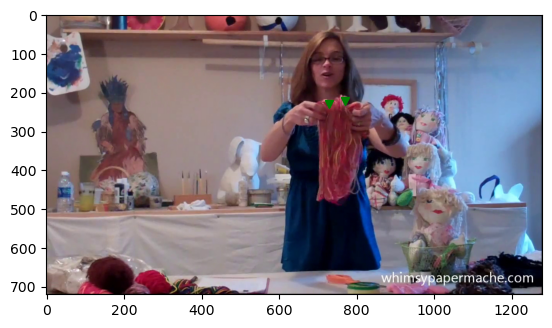

In [176]:
plt.imshow(image)
plt.plot(770, 221, marker='v', color="green") # right eye
plt.plot(729, 228, marker='v', color="green") # nose

plt.show()

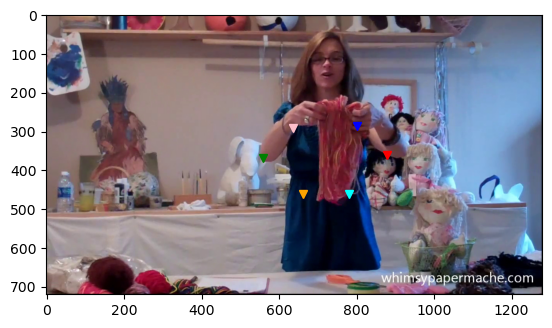

In [187]:
plt.imshow(image)
plt.plot(879, 359, marker='v', color="red") # left elbow
plt.plot(558, 368, marker='v', color="green") # right elbow
plt.plot(801, 284, marker='v', color="blue") # left shoulder
plt.plot(635, 290, marker='v', color="pink") # right elbow
plt.plot(781, 461, marker='v', color="cyan") # left hip
plt.plot(663, 462, marker='v', color="orange") # right hip


plt.show()

### testing with an image of a different pose

original size:  (720, 1280, 3)


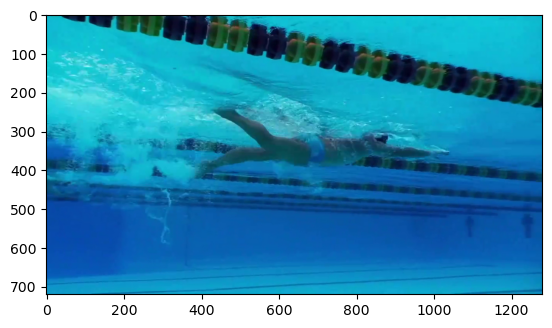

In [190]:
file_name = "mpii/061172075.jpg"
image = plt.imread(file_name)
plt.imshow(image)
print("original size: ", image.shape)

In [191]:
img = image.copy()
np.expand_dims(img, axis=0).shape
# Reshape image: 192x192x3 (Lightning)
img = image.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
# print(tf.shape(img))
input_image = tf.cast(img, dtype=tf.float32)
# Setup input and output 
input_details = interpreter.get_input_details()
# print(input_details)
output_details = interpreter.get_output_details()
# print(output_details)
# Make predictions 
interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
# print(keypoints_with_scores)
# print(keypoints_with_scores.shape)


left_elbow = keypoints_with_scores[0,0,7]
left_elbow_pt = np.array(left_elbow[:2]*[720,1280]).astype(int)
print(left_elbow_pt)

right_elbow = keypoints_with_scores[0,0,8]
right_elbow_pt = np.array(right_elbow[:2]*[720,1280]).astype(int)
print(right_elbow_pt)

left_shoulder = keypoints_with_scores[0,0,5]
left_shoulder_pt = np.array(left_shoulder[:2]*[720,1280]).astype(int)
print(left_shoulder_pt)

right_shoulder = keypoints_with_scores[0,0,6]
right_shoulder_pt = np.array(right_shoulder[:2]*[720,1280]).astype(int)
print(right_shoulder_pt)

left_hip  = keypoints_with_scores[0,0,11]
left_hip_pt = np.array(left_hip[:2]*[720,1280]).astype(int)
print(left_hip_pt)
right_hip = keypoints_with_scores[0,0,12]
right_hip_pt = np.array(right_hip[:2]*[720,1280]).astype(int)
print(right_hip_pt)

[191 574]
[197 556]
[189 541]
[189 535]
[193 584]
[193 545]


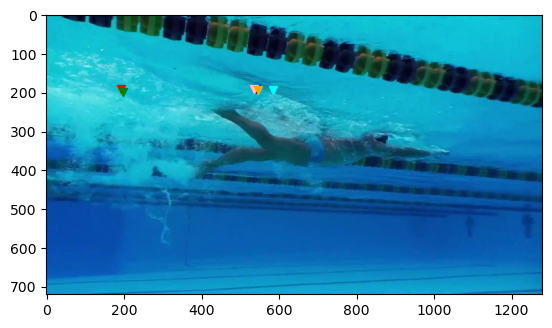

In [193]:
plt.imshow(image)
plt.plot(191, 191, marker='v', color="red") # left elbow
plt.plot(197, 197, marker='v', color="green") # right elbow
plt.plot(541, 189, marker='v', color="blue") # left shoulder
plt.plot(535, 189, marker='v', color="pink") # right elbow
plt.plot(584, 193, marker='v', color="cyan") # left hip
plt.plot(545, 193, marker='v', color="orange") # right hip


plt.show()

In [156]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1) 

In [157]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [158]:
shaped[0], shaped[1]

NameError: name 'shaped' is not defined

In [ ]:
for edge, color in EDGES.items():
    p1, p2 = edge
    y1, x1, c1 = shaped[p1]
    y2, x2, c2 = shaped[p2]
    print((int(x2), int(y2)))

In [ ]:


def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
